In [1]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

import keras
from keras import layers
from keras import layers, models, regularizers, optimizers, ops, callbacks

import pandas as pd
from numpy import loadtxt
import numpy as np
import matplotlib.pyplot as plt
import math

import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")



/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [2]:
# Load cifar10 dataset

num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [3]:
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# One-hot encode labels (Integer -> Vector)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print("Pre-processing complete.")
print(f"x_train range: {x_train.min()} to {x_train.max()}")
print(f"y_train sample [0]: {y_train[0]}")

Pre-processing complete.
x_train range: 0.0 to 1.0
y_train sample [0]: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


/tmp/ipython-input-3646208839.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=decoded_names, palette="muted")


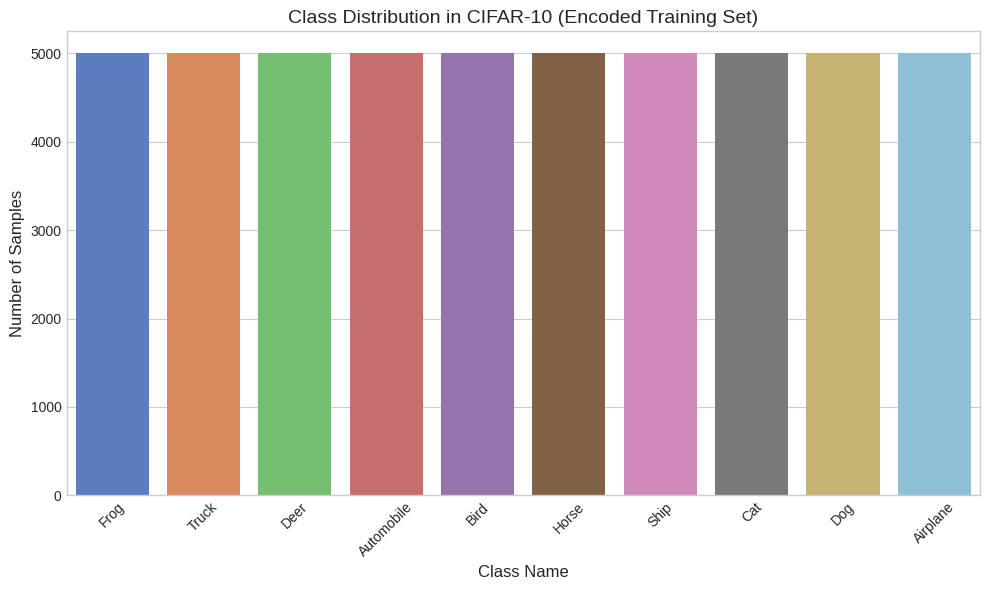

In [4]:
y_train_flat = y_train.flatten()

# map indices to class names
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

decoded_indices = np.argmax(y_train, axis=1)

decoded_names = [class_names[i] for i in decoded_indices]

plt.figure(figsize=(10, 6))
sns.countplot(x=decoded_names, palette="muted")
plt.title('Class Distribution in CIFAR-10 (Encoded Training Set)', fontsize=14)
plt.xlabel('Class Name', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

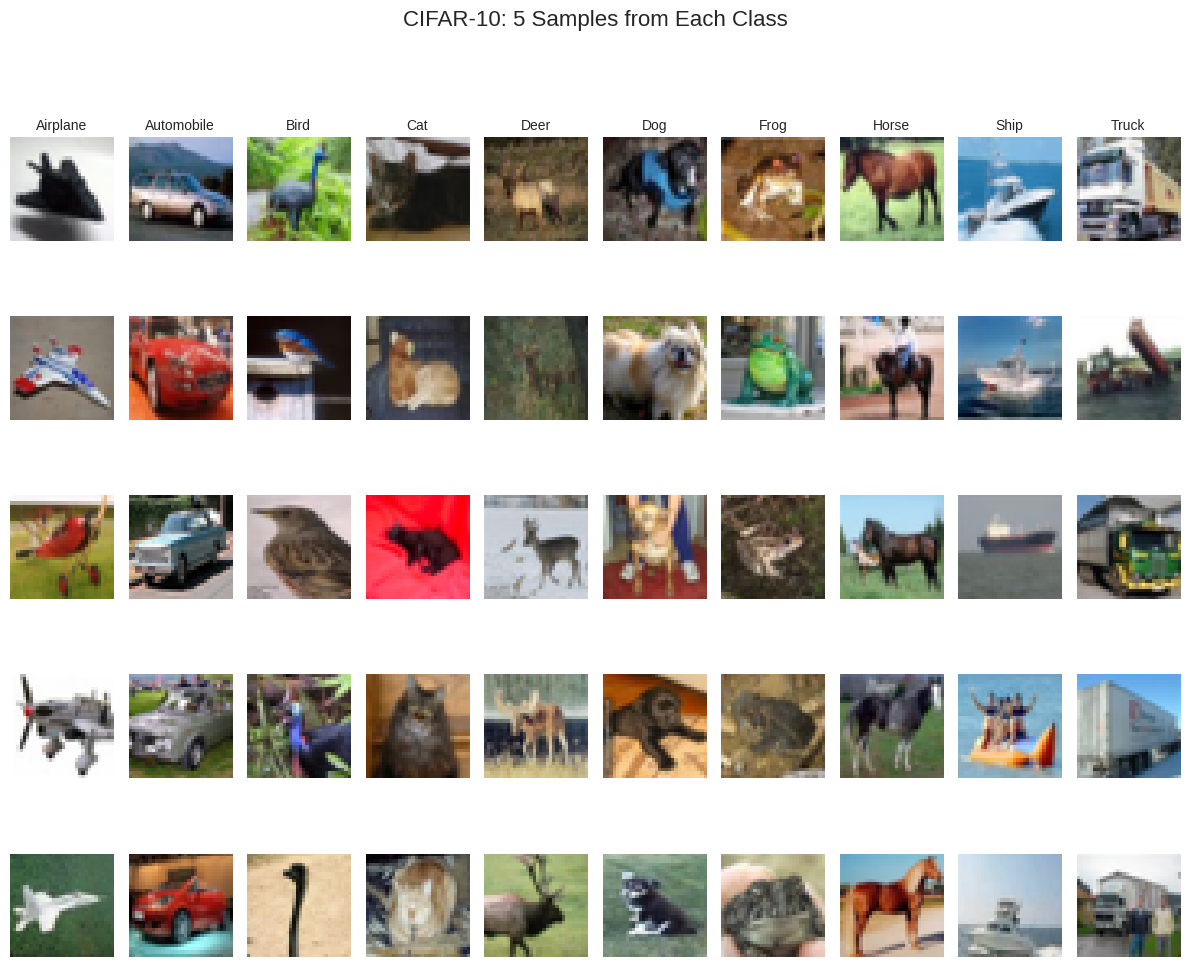

In [ ]:
def plot_sample_grid(x, y, class_names):
    num_classes = len(class_names)
    samples_per_class = 5

    # Create a figure with a row for each class and a column for each sample
    plt.figure(figsize=(12, 10))

    for class_idx, class_name in enumerate(class_names):
        # Find indices where this class has a '1' in the one-hot encoding
        indices = np.where(y[:, class_idx] == 1)[0]

        sample_indices = indices[:samples_per_class]

        for i, img_idx in enumerate(sample_indices):
            # Calculate the position in the subplot grid
            plt_idx = i * num_classes + class_idx + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)

            plt.imshow(x[img_idx])
            plt.axis('off')

            # Add the class name as a title only on the top row
            if i == 0:
                plt.title(class_name, fontsize=10)

    plt.suptitle("CIFAR-10: 5 Samples from Each Class", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Define your class names list
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

plot_sample_grid(x_train, y_train, class_names)

In [ ]:
print(f"Missing values in x_train: {np.isnan(x_train).any()}")
print(f"Missing values in x_test: {np.isnan(x_test).any()}")

Missing values in x_train: False
Missing values in x_test: False


No missing data (isnan) is present in the CIFAR-10 dataset. Outliers were handled via Min-Max scaling (Normalization) to ensure all input features occupy the same numerical range $[0, 1]$

In [ ]:
def build_cnn(input_shape, num_classes):
    model = models.Sequential([

      # Layer 1
      layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
      layers.BatchNormalization(),
      layers.MaxPooling2D(2,2),
      layers.Dropout(0.2),

      # Layer 2
      layers.Conv2D(64, (3,3), activation='relu', padding='same'),
      layers.BatchNormalization(),
      layers.MaxPooling2D(2,2),
      layers.Dropout(0.3),

      # Layer 3
      layers.Conv2D(128, (3,3), activation='relu', padding='same'),
      layers.BatchNormalization(),
      layers.Flatten(),

      # Final Classification
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
model = build_cnn((32, 32, 3), 10)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10)

lr_reducer = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0.00001
)

history = model.fit(x_train, y_train,
                    epochs=50,
                    batch_size=128,
                    validation_split=0.2,
                    verbose=2,
                    callbacks=[early_stopping, lr_reducer])

Epoch 1/50
313/313 - 38s - 122ms/step - accuracy: 0.3730 - loss: 1.7524 - val_accuracy: 0.2329 - val_loss: 4.2269 - learning_rate: 1.0000e-03
Epoch 2/50
313/313 - 13s - 42ms/step - accuracy: 0.4955 - loss: 1.4126 - val_accuracy: 0.5630 - val_loss: 1.2783 - learning_rate: 1.0000e-03
Epoch 3/50
313/313 - 0s - 2ms/step - accuracy: 0.5697 - loss: 1.2143 - val_accuracy: 0.6274 - val_loss: 1.0960 - learning_rate: 1.0000e-03
Epoch 4/50
313/313 - 0s - 2ms/step - accuracy: 0.6166 - loss: 1.0863 - val_accuracy: 0.6498 - val_loss: 1.0021 - learning_rate: 1.0000e-03
Epoch 5/50
313/313 - 0s - 2ms/step - accuracy: 0.6525 - loss: 0.9814 - val_accuracy: 0.7067 - val_loss: 0.8487 - learning_rate: 1.0000e-03
Epoch 6/50
313/313 - 0s - 1ms/step - accuracy: 0.6802 - loss: 0.9126 - val_accuracy: 0.6211 - val_loss: 1.1069 - learning_rate: 1.0000e-03
Epoch 7/50
313/313 - 0s - 2ms/step - accuracy: 0.7013 - loss: 0.8489 - val_accuracy: 0.7072 - val_loss: 0.8527 - learning_rate: 1.0000e-03
Epoch 8/50
313/313 - 0

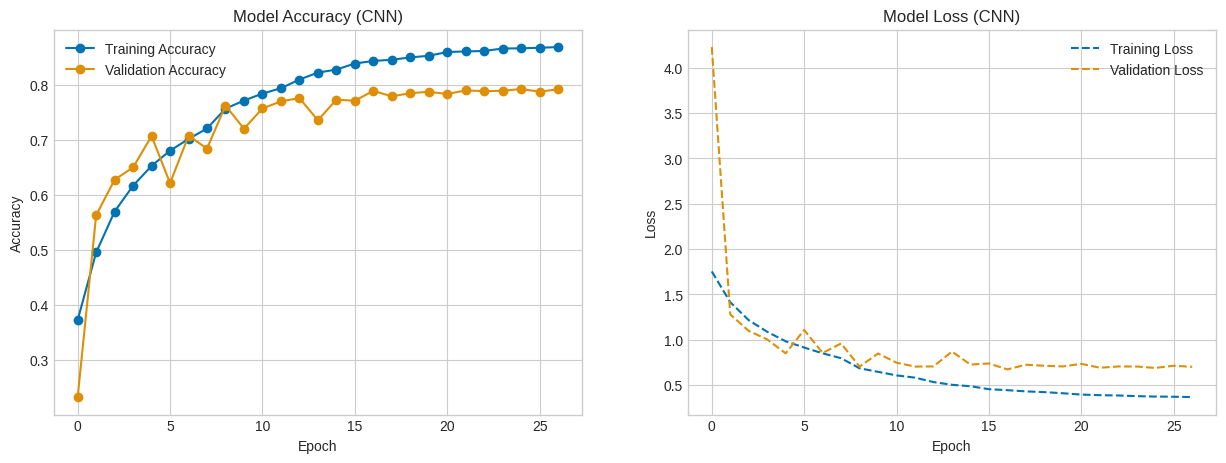

In [ ]:
plt.figure(figsize=(15, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy (CNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', linestyle='--')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Model Loss (CNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

In [4]:
# Parameters for ViT model

learning_rate = 0.001 # Increased learning rate for TPU usage
weight_decay = 0.0001
batch_size = 1024 # Increased batch size for TPU usage
num_epochs = 100
image_size = 72
patch_size = 6
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [
    1024, 512
]  # Size of the dense layers of the final classifier

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
data_augmentation.layers[0].adapt(x_train)

In [6]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config


class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [7]:
def build_vit():
    inputs = keras.Input(shape=input_shape)
    # Augment data
    augmented = data_augmentation(inputs)
    # Create patches
    patches = Patches(patch_size)(augmented)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create layers of the Transformer block
    for _ in range(transformer_layers):
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs
    logits = layers.Dense(num_classes)(features)

    model = keras.Model(inputs=inputs, outputs=logits)

    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True), # Data is one hot encoded
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
        ],
    )

    return model

In [8]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,           # Increased attention time due to "noisy" behaviour of ViT training
    restore_best_weights=True
)

lr_reducer = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,            # Dropping by 5x instead of 2x can be more effective for ViTs
    patience=7,
    min_lr=1e-6
)

In [9]:
import os

checkpoint_dir = "/content/drive/MyDrive/ViT_Results"
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_filepath = os.path.join(checkpoint_dir, "vit_cifar10.weights.h5")
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

In [10]:
model_vit = build_vit()

history_vit = model_vit.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[early_stopping, lr_reducer, checkpoint_callback],
    )

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 382s 8s/step - accuracy: 0.1913 - loss: 2.9752 - val_accuracy: 0.3738 - val_loss: 1.7693 - learning_rate: 0.0010
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 228s 5s/step - accuracy: 0.3139 - loss: 1.8829 - val_accuracy: 0.4416 - val_loss: 1.5192 - learning_rate: 0.0010
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 228s 5s/step - accuracy: 0.3895 - loss: 1.6976 - val_accuracy: 0.4930 - val_loss: 1.3933 - learning_rate: 0.0010
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 227s 5s/step - accuracy: 0.4398 - loss: 1.5484 - val_accuracy: 0.5534 - val_loss: 1.3008 - learning_rate: 0.0010
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 228s 5s/step - accuracy: 0.4821 - loss: 1.4479 - val_accuracy: 0.5692 - val_loss: 1.2676 - learning_rate: 0.0010
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 228s 5s/step - accuracy: 0.5073 - loss: 1.3701 - val_accuracy: 0.5888 - val_loss: 1.2120 - learning_rate: 0.0010
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 227s 5s/step - accuracy: 0.5305 - loss: 1.3162 - 

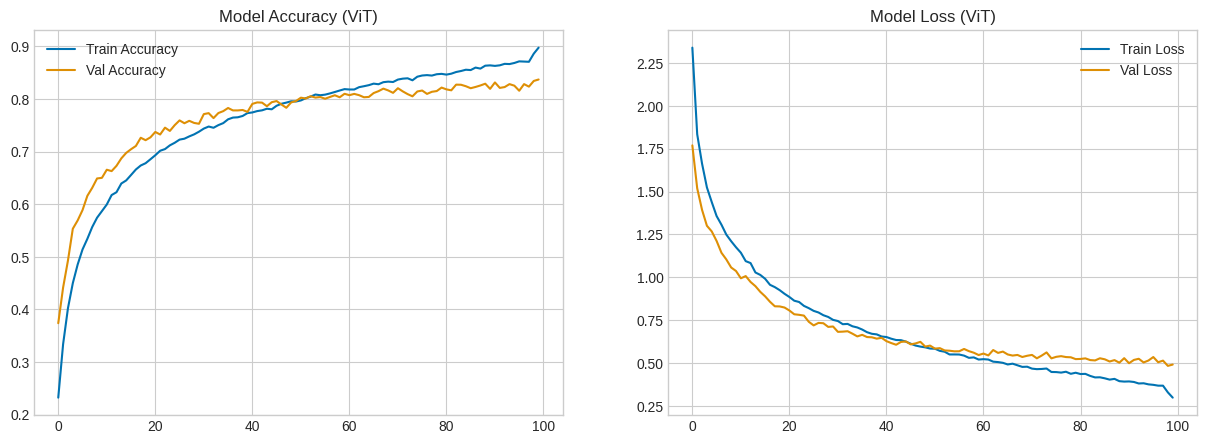

In [11]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history_vit.history['accuracy'], label='Train Accuracy')
plt.plot(history_vit.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy (ViT)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_vit.history['loss'], label='Train Loss')
plt.plot(history_vit.history['val_loss'], label='Val Loss')
plt.title('Model Loss (ViT)')
plt.legend()
plt.show()